In [20]:
import warnings
warnings.filterwarnings("ignore")
import os,logging
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [21]:
# Workspace problem with several narrow gaps
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random
import time
import pathlib
import cv2
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

In [22]:
tf.test.is_gpu_available()

True

# Clarification
Due to the loading of the array in MATLAB is transposed, column wise and not row wise, the data generated is of the format ```(y_sample,x_sample,y_init,x_init)```
Therefore the needful must be done to properly visualise the sampled points.

In [32]:
STATE_DIM = 2  # state dimension x, y
VALS_PER_SAMPLE = 6  # number of numbers per training sample
SAMPLE_SCALE_UP = 160
MAP_NUM = 2  # which map training on
DATA_ROOT = './Training_Data'
MODEL_DIR = './Models/0'+str(MAP_NUM)
# Parse sampling data
samples_file = os.path.join(DATA_ROOT, 'nodes_{}.txt'.format(MAP_NUM))
with open(samples_file, 'r') as f:
  txt_rows = f.read().split("\n")
  data_list = []
  for row in txt_rows:
    new_data = []
    for val in row.split(" "):
      try:
        num = float(val)
        new_data.append(num)
      except ValueError:
        continue
    if len(new_data) == VALS_PER_SAMPLE:
      data_list.append(new_data)
    else:
      print("Error parsing a line: %s" % row)
sample_data = np.array(data_list,dtype='float')

# Load original map that was sampled from
orig_map_file = os.path.join(DATA_ROOT, 'map{}.npy'.format(MAP_NUM))
orig_map = np.load(orig_map_file)

# Parse mini map that was sampled from for training
mini_map_file = os.path.join(DATA_ROOT, 'map{}_mini.npy'.format(MAP_NUM))
map_data = np.load(mini_map_file)
print("Done!")




Error parsing a line: 
Done!


Network Hyperparameters

In [33]:
# neural network parameters
mb_size = 256  # mini batch GD size
h_Q_dim = 512
h_P_dim = 512
z_dim = 3 # latent
c = 0  # 
lr = 1e-4  # learning rate
state_weights = [[1, 1]]  # both states (x,y) are equally important
TRAIN_ITERS = 500000
ITERS_PER_SAVE = 10000

# split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)
ratioTestTrain = 0.8
numEntries = sample_data.shape[0]
numTrain = int(numEntries*ratioTestTrain)
numTest = numEntries - numTrain

# x_train and x_test are the samples from solved paths
x_train = sample_data[:numTrain, :STATE_DIM] # state: row, col
x_test = sample_data[numTrain:, :STATE_DIM]  # other part of data

# cond_data 1D array of concatenated [init, goal, map]
unrolled_map = np.concatenate(map_data, axis=0)
COND_DIM = STATE_DIM + STATE_DIM + len(unrolled_map)  # init + goal + map
cond_data = np.zeros((numEntries, COND_DIM))
for r in range(numEntries):
  cond_data[r,:] = np.concatenate([sample_data[r,STATE_DIM:], unrolled_map], axis=0)

cond_train = cond_data[:numTrain, :]
cond_test = cond_data[numTrain:, :]

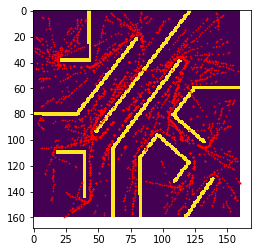

0.504728 0.358499
80.75648 57.359840000000005
0.284867 0.529486
45.57872 84.71776
0.287249 0.544158
45.95984 87.06528
0.288075 0.668957
46.092000000000006 107.03312
0.395877 0.761317
63.34032 121.81072
0.405438 0.765933
64.87008 122.54928
0.578177 0.752816
92.50832000000001 120.45056000000001
0.669833 0.540254
107.17328 86.44064
0.675676 0.538462
108.10816000000001 86.15392


In [34]:
# Load original map that was sampled from and print any collisions
orig_map_file = os.path.join(DATA_ROOT, 'map{}.npy'.format(MAP_NUM))
orig_map = np.load(orig_map_file)
plt.imshow(orig_map)
plt.scatter(x=x_train[:,1]*SAMPLE_SCALE_UP, y=x_train[:,0]*SAMPLE_SCALE_UP, color="red", s=0.5,) # init
plt.show()
x=x_train[:,0]*SAMPLE_SCALE_UP
y=x_train[:,1]*SAMPLE_SCALE_UP
for i,j in zip(x_train[:,0],x_train[:,1]):
  if orig_map[int(i*SAMPLE_SCALE_UP),int(j*SAMPLE_SCALE_UP)]==1:
    print(i,j)
    print(i*SAMPLE_SCALE_UP,j*SAMPLE_SCALE_UP)

# Training
To rename output tensors ``` tf.identity(z, name="z")``` 

In [18]:
# define networks
X = tf.placeholder(tf.float32, shape=[None, STATE_DIM], name="X")
c = tf.placeholder(tf.float32, shape=[None, COND_DIM], name="c")

# Q (Encoder)
inputs_Q = tf.concat(axis=1, values=[X,c])

dense_Q1 = tf.layers.dense(inputs=inputs_Q, units=h_Q_dim, activation=tf.nn.relu)
dropout_Q1 = tf.layers.dropout(inputs=dense_Q1, rate=0.5)
dense_Q2 = tf.layers.dense(inputs=dropout_Q1, units=h_Q_dim, activation=tf.nn.relu)

z_mu = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_mu
z_logvar = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_logvar

# P (Reparameterisation tricks)
eps = tf.random_normal(shape=tf.shape(z_mu))
z = tf.add(z_mu, tf.exp(z_logvar / 2) * eps)
inputs_P = tf.concat(axis=1, values=[z,c])

# (Decoder)
dense_P1 = tf.layers.dense(inputs=inputs_P, units=h_P_dim, activation=tf.nn.relu)
dropout_P1 = tf.layers.dropout(inputs=dense_P1, rate=0.5)
dense_P2 = tf.layers.dense(inputs=dropout_P1, units=h_P_dim, activation=tf.nn.relu)

y = tf.layers.dense(inputs=dense_P2, units=STATE_DIM) # fix to also output y

# training
recon_loss = tf.losses.mean_squared_error(labels=X, predictions=y, weights=state_weights)
# TODO: fix loss function for angles going around
kl_loss = 10**-4 * 2 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

cvae_loss = tf.reduce_mean(kl_loss + recon_loss)

train_step = tf.train.AdamOptimizer(lr).minimize(cvae_loss)

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
tf.train.export_meta_graph(MODEL_DIR+'/graph.meta')
it = 0;

Iter: 0
Loss: 0.5162



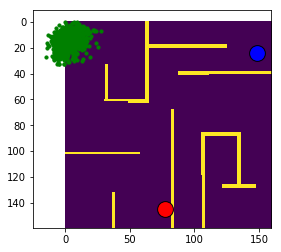

Iter: 1000
Loss: 0.002748

Iter: 2000
Loss: 0.0025

Iter: 3000
Loss: 0.002534

Iter: 4000
Loss: 0.00267

Iter: 5000
Loss: 0.002367

Iter: 6000
Loss: 0.002535

Iter: 7000
Loss: 0.002454

Iter: 8000
Loss: 0.002691

Iter: 9000
Loss: 0.002468

Iter: 10000
Loss: 0.002191



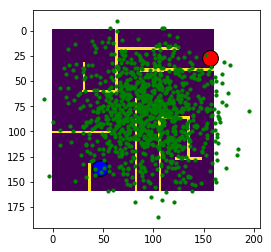

Iter: 11000
Loss: 0.002344

Iter: 12000
Loss: 0.002246

Iter: 13000
Loss: 0.002623

Iter: 14000
Loss: 0.002321

Iter: 15000
Loss: 0.002202

Iter: 16000
Loss: 0.00232

Iter: 17000
Loss: 0.002302

Iter: 18000
Loss: 0.002212

Iter: 19000
Loss: 0.002235

Iter: 20000
Loss: 0.002459



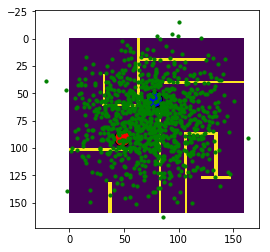

Iter: 21000
Loss: 0.002181

Iter: 22000
Loss: 0.002837

Iter: 23000
Loss: 0.002151

Iter: 24000
Loss: 0.002332

Iter: 25000
Loss: 0.002515

Iter: 26000
Loss: 0.002174

Iter: 27000
Loss: 0.002288

Iter: 28000
Loss: 0.002263

Iter: 29000
Loss: 0.002111

Iter: 30000
Loss: 0.002241



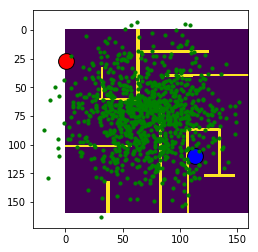

Iter: 31000
Loss: 0.002224

Iter: 32000
Loss: 0.002259

Iter: 33000
Loss: 0.002123

Iter: 34000
Loss: 0.002165

Iter: 35000
Loss: 0.002345

Iter: 36000
Loss: 0.002266

Iter: 37000
Loss: 0.002226

Iter: 38000
Loss: 0.002131

Iter: 39000
Loss: 0.002403

Iter: 40000
Loss: 0.002205



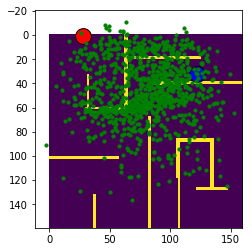

Iter: 41000
Loss: 0.002225

Iter: 42000
Loss: 0.002242

Iter: 43000
Loss: 0.002096

Iter: 44000
Loss: 0.002136

Iter: 45000
Loss: 0.002101

Iter: 46000
Loss: 0.002192

Iter: 47000
Loss: 0.002072

Iter: 48000
Loss: 0.002105

Iter: 49000
Loss: 0.002153

Iter: 50000
Loss: 0.002035



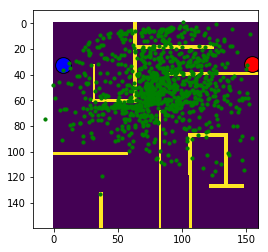

Iter: 51000
Loss: 0.002217

Iter: 52000
Loss: 0.002054

Iter: 53000
Loss: 0.002089

Iter: 54000
Loss: 0.002106

Iter: 55000
Loss: 0.002138

Iter: 56000
Loss: 0.001941

Iter: 57000
Loss: 0.002034

Iter: 58000
Loss: 0.002055

Iter: 59000
Loss: 0.002004

Iter: 60000
Loss: 0.002053



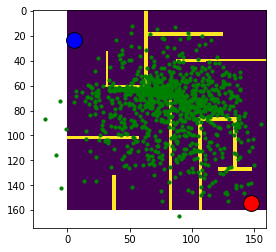

Iter: 61000
Loss: 0.002037

Iter: 62000
Loss: 0.001942

Iter: 63000
Loss: 0.001982

Iter: 64000
Loss: 0.00199

Iter: 65000
Loss: 0.002097

Iter: 66000
Loss: 0.002141

Iter: 67000
Loss: 0.001967

Iter: 68000
Loss: 0.002174

Iter: 69000
Loss: 0.002085

Iter: 70000
Loss: 0.001955



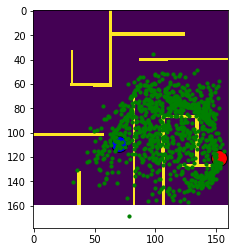

Iter: 71000
Loss: 0.002037

Iter: 72000
Loss: 0.002043

Iter: 73000
Loss: 0.001956

Iter: 74000
Loss: 0.00203

Iter: 75000
Loss: 0.001928

Iter: 76000
Loss: 0.001939

Iter: 77000
Loss: 0.001955

Iter: 78000
Loss: 0.001924

Iter: 79000
Loss: 0.001943

Iter: 80000
Loss: 0.001926



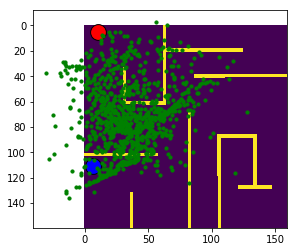

Iter: 81000
Loss: 0.002115

Iter: 82000
Loss: 0.0019

Iter: 83000
Loss: 0.002196

Iter: 84000
Loss: 0.002064

Iter: 85000
Loss: 0.002051

Iter: 86000
Loss: 0.001991

Iter: 87000
Loss: 0.002037

Iter: 88000
Loss: 0.001893

Iter: 89000
Loss: 0.001824

Iter: 90000
Loss: 0.002093



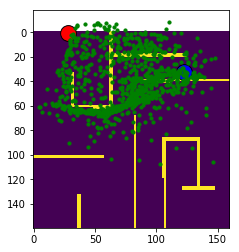

Iter: 91000
Loss: 0.001968

Iter: 92000
Loss: 0.0018

Iter: 93000
Loss: 0.001825

Iter: 94000
Loss: 0.00188

Iter: 95000
Loss: 0.001865

Iter: 96000
Loss: 0.001911

Iter: 97000
Loss: 0.001947

Iter: 98000
Loss: 0.001906

Iter: 99000
Loss: 0.001887

Iter: 100000
Loss: 0.001942



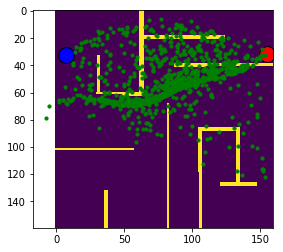

Iter: 101000
Loss: 0.001858

Iter: 102000
Loss: 0.001829

Iter: 103000
Loss: 0.001855

Iter: 104000
Loss: 0.001784

Iter: 105000
Loss: 0.001875

Iter: 106000
Loss: 0.001838

Iter: 107000
Loss: 0.001874

Iter: 108000
Loss: 0.001785

Iter: 109000
Loss: 0.001846

Iter: 110000
Loss: 0.001855



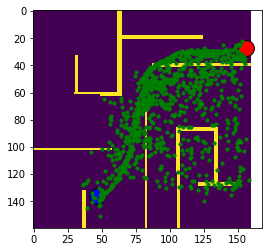

Iter: 111000
Loss: 0.001814

Iter: 112000
Loss: 0.001811

Iter: 113000
Loss: 0.001935

Iter: 114000
Loss: 0.001836

Iter: 115000
Loss: 0.001846

Iter: 116000
Loss: 0.001839

Iter: 117000
Loss: 0.001791

Iter: 118000
Loss: 0.001858

Iter: 119000
Loss: 0.00184

Iter: 120000
Loss: 0.002002



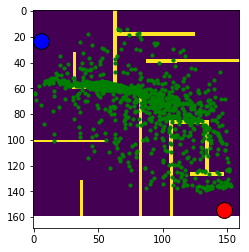

Iter: 121000
Loss: 0.00186

Iter: 122000
Loss: 0.001842

Iter: 123000
Loss: 0.001864

Iter: 124000
Loss: 0.001806

Iter: 125000
Loss: 0.001805

Iter: 126000
Loss: 0.00185

Iter: 127000
Loss: 0.001736

Iter: 128000
Loss: 0.001758

Iter: 129000
Loss: 0.001886

Iter: 130000
Loss: 0.001923



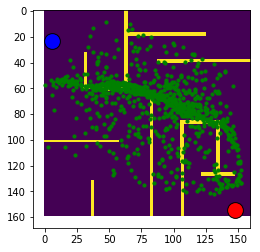

Iter: 131000
Loss: 0.001904

Iter: 132000
Loss: 0.001789

Iter: 133000
Loss: 0.001788

Iter: 134000
Loss: 0.001953

Iter: 135000
Loss: 0.001802

Iter: 136000
Loss: 0.00175

Iter: 137000
Loss: 0.001795

Iter: 138000
Loss: 0.001724

Iter: 139000
Loss: 0.001688

Iter: 140000
Loss: 0.001793



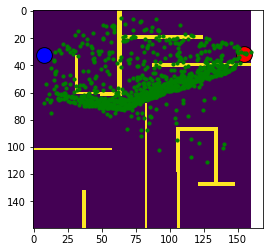

Iter: 141000
Loss: 0.001745

Iter: 142000
Loss: 0.001718

Iter: 143000
Loss: 0.00166

Iter: 144000
Loss: 0.001839

Iter: 145000
Loss: 0.001763

Iter: 146000
Loss: 0.001744

Iter: 147000
Loss: 0.0018

Iter: 148000
Loss: 0.001745

Iter: 149000
Loss: 0.001724

Iter: 150000
Loss: 0.001704



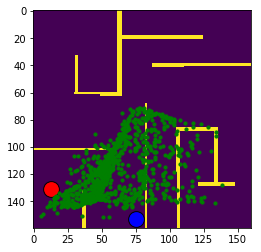

Iter: 151000
Loss: 0.001777

Iter: 152000
Loss: 0.0018

Iter: 153000
Loss: 0.001843

Iter: 154000
Loss: 0.001691

Iter: 155000
Loss: 0.001711

Iter: 156000
Loss: 0.001666

Iter: 157000
Loss: 0.001736

Iter: 158000
Loss: 0.001846

Iter: 159000
Loss: 0.001696

Iter: 160000
Loss: 0.00181



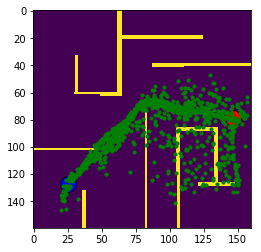

Iter: 161000
Loss: 0.001633

Iter: 162000
Loss: 0.00163

Iter: 163000
Loss: 0.001798

Iter: 164000
Loss: 0.001662

Iter: 165000
Loss: 0.001835

Iter: 166000
Loss: 0.001714

Iter: 167000
Loss: 0.001663

Iter: 168000
Loss: 0.001704

Iter: 169000
Loss: 0.001738

Iter: 170000
Loss: 0.001642



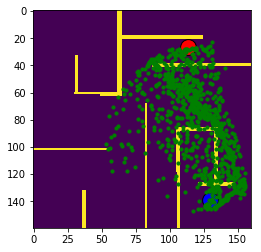

Iter: 171000
Loss: 0.001712

Iter: 172000
Loss: 0.001704

Iter: 173000
Loss: 0.001705

Iter: 174000
Loss: 0.001693

Iter: 175000
Loss: 0.001732

Iter: 176000
Loss: 0.001717

Iter: 177000
Loss: 0.001713

Iter: 178000
Loss: 0.001605

Iter: 179000
Loss: 0.001663

Iter: 180000
Loss: 0.001721



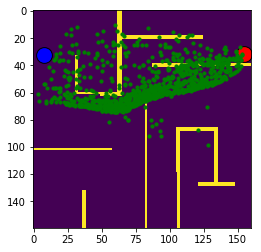

Iter: 181000
Loss: 0.001693

Iter: 182000
Loss: 0.001682

Iter: 183000
Loss: 0.001713

Iter: 184000
Loss: 0.001638

Iter: 185000
Loss: 0.001655

Iter: 186000
Loss: 0.001674

Iter: 187000
Loss: 0.001582

Iter: 188000
Loss: 0.001697

Iter: 189000
Loss: 0.00165

Iter: 190000
Loss: 0.001802



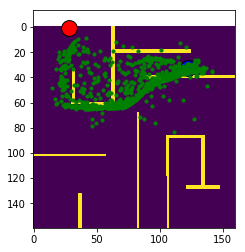

Iter: 191000
Loss: 0.001665

Iter: 192000
Loss: 0.001653

Iter: 193000
Loss: 0.001655

Iter: 194000
Loss: 0.001641

Iter: 195000
Loss: 0.00175

Iter: 196000
Loss: 0.001687

Iter: 197000
Loss: 0.001694

Iter: 198000
Loss: 0.001593

Iter: 199000
Loss: 0.001615

Iter: 200000
Loss: 0.00166



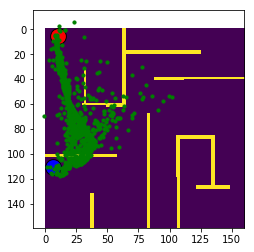

Iter: 201000
Loss: 0.001693

Iter: 202000
Loss: 0.001575

Iter: 203000
Loss: 0.001635

Iter: 204000
Loss: 0.001624

Iter: 205000
Loss: 0.001573

Iter: 206000
Loss: 0.001639

Iter: 207000
Loss: 0.001614

Iter: 208000
Loss: 0.001573

Iter: 209000
Loss: 0.001678

Iter: 210000
Loss: 0.001626



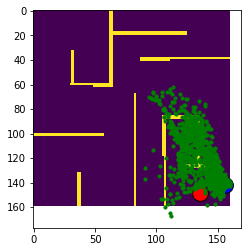

Iter: 211000
Loss: 0.001655

Iter: 212000
Loss: 0.001596

Iter: 213000
Loss: 0.001667

Iter: 214000
Loss: 0.001694

Iter: 215000
Loss: 0.001719

Iter: 216000
Loss: 0.001652

Iter: 217000
Loss: 0.001644

Iter: 218000
Loss: 0.001608

Iter: 219000
Loss: 0.00165

Iter: 220000
Loss: 0.001585



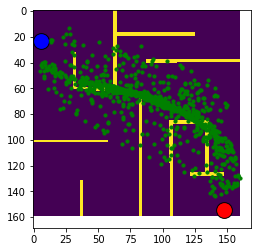

Iter: 221000
Loss: 0.001669

Iter: 222000
Loss: 0.001626

Iter: 223000
Loss: 0.001614

Iter: 224000
Loss: 0.001583

Iter: 225000
Loss: 0.001609

Iter: 226000
Loss: 0.001555

Iter: 227000
Loss: 0.001574

Iter: 228000
Loss: 0.0016

Iter: 229000
Loss: 0.001615

Iter: 230000
Loss: 0.00155



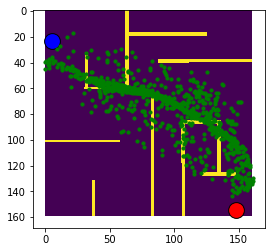

Iter: 231000
Loss: 0.001615

Iter: 232000
Loss: 0.001604

Iter: 233000
Loss: 0.001509

Iter: 234000
Loss: 0.001772

Iter: 235000
Loss: 0.00158

Iter: 236000
Loss: 0.001652

Iter: 237000
Loss: 0.001628

Iter: 238000
Loss: 0.001595

Iter: 239000
Loss: 0.001561

Iter: 240000
Loss: 0.001683



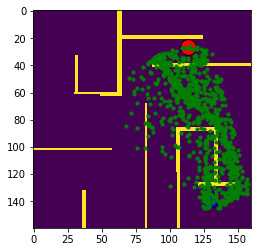

Iter: 241000
Loss: 0.001617

Iter: 242000
Loss: 0.001658

Iter: 243000
Loss: 0.001578

Iter: 244000
Loss: 0.001672

Iter: 245000
Loss: 0.001591

Iter: 246000
Loss: 0.001579

Iter: 247000
Loss: 0.001726

Iter: 248000
Loss: 0.001697

Iter: 249000
Loss: 0.001636

Iter: 250000
Loss: 0.001545



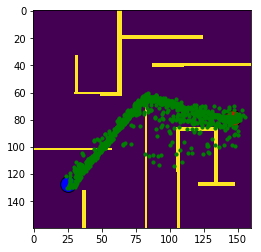

Iter: 251000
Loss: 0.001662

Iter: 252000
Loss: 0.00157

Iter: 253000
Loss: 0.001588

Iter: 254000
Loss: 0.001592

Iter: 255000
Loss: 0.00165

Iter: 256000
Loss: 0.001594

Iter: 257000
Loss: 0.001567

Iter: 258000
Loss: 0.001688

Iter: 259000
Loss: 0.001613

Iter: 260000
Loss: 0.001572



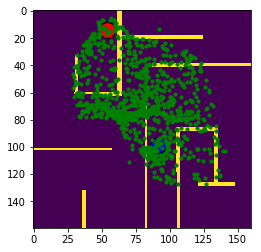

Iter: 261000
Loss: 0.001619

Iter: 262000
Loss: 0.001528

Iter: 263000
Loss: 0.001512

Iter: 264000
Loss: 0.001505

Iter: 265000
Loss: 0.001625

Iter: 266000
Loss: 0.001595

Iter: 267000
Loss: 0.001649

Iter: 268000
Loss: 0.001602

Iter: 269000
Loss: 0.001602

Iter: 270000
Loss: 0.001575



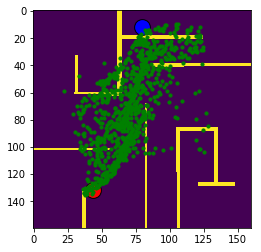

Iter: 271000
Loss: 0.001578

Iter: 272000
Loss: 0.001655

Iter: 273000
Loss: 0.001509

Iter: 274000
Loss: 0.001549

Iter: 275000
Loss: 0.001525

Iter: 276000
Loss: 0.001645

Iter: 277000
Loss: 0.001554

Iter: 278000
Loss: 0.001539

Iter: 279000
Loss: 0.001583

Iter: 280000
Loss: 0.001573



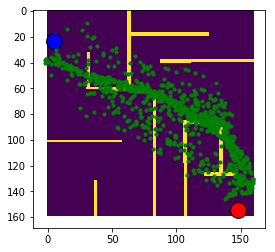

Iter: 281000
Loss: 0.001601

Iter: 282000
Loss: 0.00161

Iter: 283000
Loss: 0.001529

Iter: 284000
Loss: 0.001427

Iter: 285000
Loss: 0.001551

Iter: 286000
Loss: 0.001576

Iter: 287000
Loss: 0.001606

Iter: 288000
Loss: 0.001684

Iter: 289000
Loss: 0.001572

Iter: 290000
Loss: 0.001534



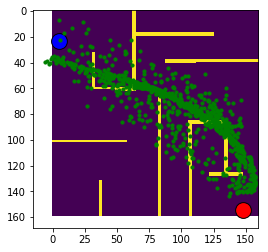

Iter: 291000
Loss: 0.001582

Iter: 292000
Loss: 0.001521

Iter: 293000
Loss: 0.001617

Iter: 294000
Loss: 0.001503

Iter: 295000
Loss: 0.001559

Iter: 296000
Loss: 0.001514

Iter: 297000
Loss: 0.001495

Iter: 298000
Loss: 0.001501

Iter: 299000
Loss: 0.00167

Iter: 300000
Loss: 0.001562



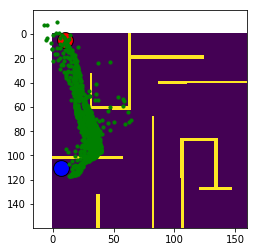

Iter: 301000
Loss: 0.001516

Iter: 302000
Loss: 0.001541

Iter: 303000
Loss: 0.001488

Iter: 304000
Loss: 0.0016

Iter: 305000
Loss: 0.001565

Iter: 306000
Loss: 0.001527

Iter: 307000
Loss: 0.001564

Iter: 308000
Loss: 0.001566

Iter: 309000
Loss: 0.001536

Iter: 310000
Loss: 0.001543



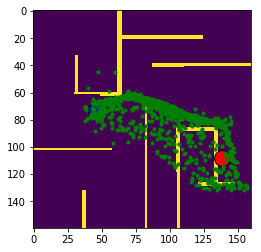

Iter: 311000
Loss: 0.001544

Iter: 312000
Loss: 0.001532

Iter: 313000
Loss: 0.001531

Iter: 314000
Loss: 0.001471

Iter: 315000
Loss: 0.001653

Iter: 316000
Loss: 0.001566

Iter: 317000
Loss: 0.001512

Iter: 318000
Loss: 0.001488

Iter: 319000
Loss: 0.001547

Iter: 320000
Loss: 0.001474



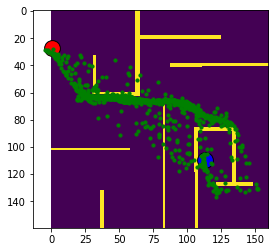

Iter: 321000
Loss: 0.001602

Iter: 322000
Loss: 0.001684

Iter: 323000
Loss: 0.00155

Iter: 324000
Loss: 0.00156

Iter: 325000
Loss: 0.001605

Iter: 326000
Loss: 0.001436

Iter: 327000
Loss: 0.001573

Iter: 328000
Loss: 0.001496

Iter: 329000
Loss: 0.001552

Iter: 330000
Loss: 0.001562



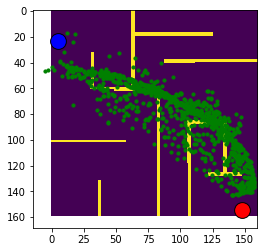

Iter: 331000
Loss: 0.001563

Iter: 332000
Loss: 0.001591

Iter: 333000
Loss: 0.001481

Iter: 334000
Loss: 0.001602

Iter: 335000
Loss: 0.001512

Iter: 336000
Loss: 0.001537

Iter: 337000
Loss: 0.001519

Iter: 338000
Loss: 0.00148

Iter: 339000
Loss: 0.001536

Iter: 340000
Loss: 0.001493



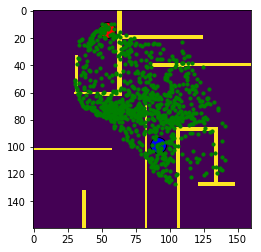

Iter: 341000
Loss: 0.001538

Iter: 342000
Loss: 0.001443

Iter: 343000
Loss: 0.001449

Iter: 344000
Loss: 0.001576

Iter: 345000
Loss: 0.001524

Iter: 346000
Loss: 0.00162

Iter: 347000
Loss: 0.001547

Iter: 348000
Loss: 0.00151

Iter: 349000
Loss: 0.00156

Iter: 350000
Loss: 0.001549



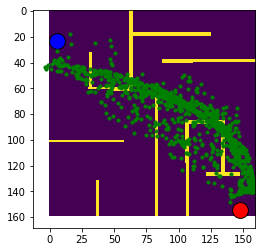

Iter: 351000
Loss: 0.001513

Iter: 352000
Loss: 0.001497

Iter: 353000
Loss: 0.001479

Iter: 354000
Loss: 0.001571

Iter: 355000
Loss: 0.001579

Iter: 356000
Loss: 0.001562

Iter: 357000
Loss: 0.001498

Iter: 358000
Loss: 0.001556

Iter: 359000
Loss: 0.001482

Iter: 360000
Loss: 0.001523



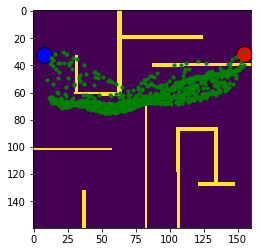

Iter: 361000
Loss: 0.001497

Iter: 362000
Loss: 0.001456

Iter: 363000
Loss: 0.001476

Iter: 364000
Loss: 0.001567

Iter: 365000
Loss: 0.001469

Iter: 366000
Loss: 0.001528

Iter: 367000
Loss: 0.001472

Iter: 368000
Loss: 0.001499

Iter: 369000
Loss: 0.001504

Iter: 370000
Loss: 0.001489



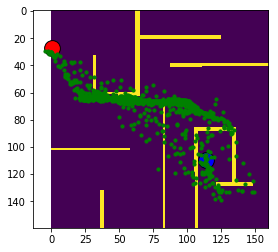

Iter: 371000
Loss: 0.001584

Iter: 372000
Loss: 0.001556

Iter: 373000
Loss: 0.001524

Iter: 374000
Loss: 0.00151

Iter: 375000
Loss: 0.001546

Iter: 376000
Loss: 0.001604

Iter: 377000
Loss: 0.001473

Iter: 378000
Loss: 0.001631

Iter: 379000
Loss: 0.001521

Iter: 380000
Loss: 0.001551



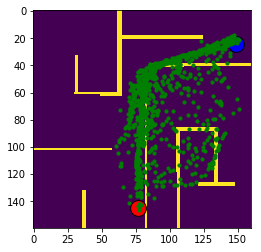

Iter: 381000
Loss: 0.00146

Iter: 382000
Loss: 0.001488

Iter: 383000
Loss: 0.001501

Iter: 384000
Loss: 0.001563

Iter: 385000
Loss: 0.001542

Iter: 386000
Loss: 0.00146

Iter: 387000
Loss: 0.001534

Iter: 388000
Loss: 0.00149

Iter: 389000
Loss: 0.00153

Iter: 390000
Loss: 0.001539



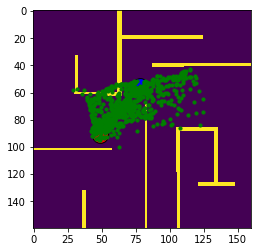

Iter: 391000
Loss: 0.001502

Iter: 392000
Loss: 0.001529

Iter: 393000
Loss: 0.001479

Iter: 394000
Loss: 0.001543

Iter: 395000
Loss: 0.001676

Iter: 396000
Loss: 0.001479

Iter: 397000
Loss: 0.0015

Iter: 398000
Loss: 0.001481

Iter: 399000
Loss: 0.001538

Iter: 400000
Loss: 0.001529



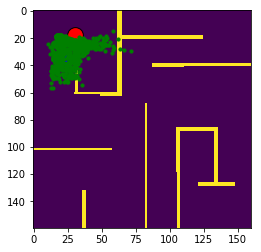

Iter: 401000
Loss: 0.001512

Iter: 402000
Loss: 0.001566

Iter: 403000
Loss: 0.001522

Iter: 404000
Loss: 0.001537

Iter: 405000
Loss: 0.001489

Iter: 406000
Loss: 0.001487

Iter: 407000
Loss: 0.001521

Iter: 408000
Loss: 0.001459

Iter: 409000
Loss: 0.001466

Iter: 410000
Loss: 0.001444



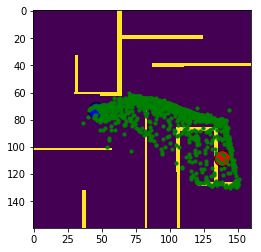

Iter: 411000
Loss: 0.001476

Iter: 412000
Loss: 0.001519

Iter: 413000
Loss: 0.001517

Iter: 414000
Loss: 0.001545

Iter: 415000
Loss: 0.001645

Iter: 416000
Loss: 0.001469

Iter: 417000
Loss: 0.001547

Iter: 418000
Loss: 0.001526

Iter: 419000
Loss: 0.001483

Iter: 420000
Loss: 0.001467



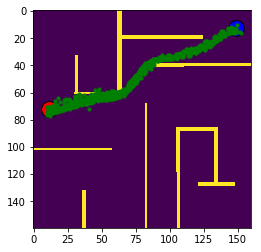

Iter: 421000
Loss: 0.00146

Iter: 422000
Loss: 0.001783

Iter: 423000
Loss: 0.001529

Iter: 424000
Loss: 0.001457

Iter: 425000
Loss: 0.001576

Iter: 426000
Loss: 0.001535

Iter: 427000
Loss: 0.001605

Iter: 428000
Loss: 0.001591

Iter: 429000
Loss: 0.001554

Iter: 430000
Loss: 0.00147



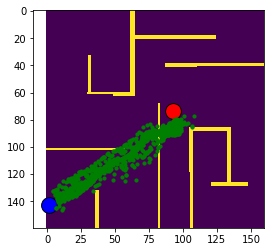

Iter: 431000
Loss: 0.00154

Iter: 432000
Loss: 0.001434

Iter: 433000
Loss: 0.001495

Iter: 434000
Loss: 0.001414

Iter: 435000
Loss: 0.001437

Iter: 436000
Loss: 0.00155

Iter: 437000
Loss: 0.001431

Iter: 438000
Loss: 0.001462

Iter: 439000
Loss: 0.001508

Iter: 440000
Loss: 0.001424



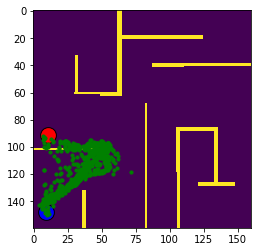

Iter: 441000
Loss: 0.001548

Iter: 442000
Loss: 0.001423

Iter: 443000
Loss: 0.001416

Iter: 444000
Loss: 0.001459

Iter: 445000
Loss: 0.001497

Iter: 446000
Loss: 0.00152

Iter: 447000
Loss: 0.001561

Iter: 448000
Loss: 0.001536

Iter: 449000
Loss: 0.001507

Iter: 450000
Loss: 0.001519



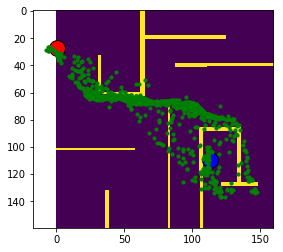

Iter: 451000
Loss: 0.001406

Iter: 452000
Loss: 0.001512

Iter: 453000
Loss: 0.001433

Iter: 454000
Loss: 0.001484

Iter: 455000
Loss: 0.001433

Iter: 456000
Loss: 0.001428

Iter: 457000
Loss: 0.001595

Iter: 458000
Loss: 0.00144

Iter: 459000
Loss: 0.001525

Iter: 460000
Loss: 0.00147



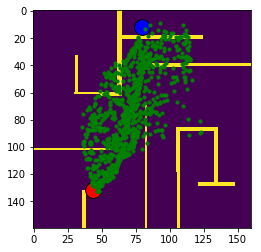

Iter: 461000
Loss: 0.001445

Iter: 462000
Loss: 0.001487

Iter: 463000
Loss: 0.001512

Iter: 464000
Loss: 0.001442

Iter: 465000
Loss: 0.001429

Iter: 466000
Loss: 0.001755

Iter: 467000
Loss: 0.001436

Iter: 468000
Loss: 0.001581

Iter: 469000
Loss: 0.001455

Iter: 470000
Loss: 0.001511



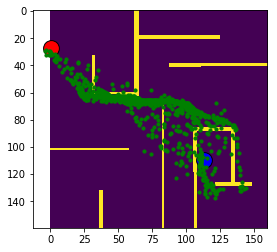

Iter: 471000
Loss: 0.001558

Iter: 472000
Loss: 0.001468

Iter: 473000
Loss: 0.001558

Iter: 474000
Loss: 0.001418

Iter: 475000
Loss: 0.001475

Iter: 476000
Loss: 0.001439

Iter: 477000
Loss: 0.001543

Iter: 478000
Loss: 0.001401

Iter: 479000
Loss: 0.001447

Iter: 480000
Loss: 0.001575



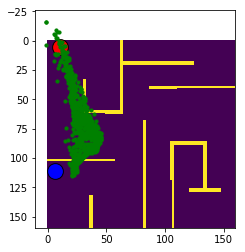

Iter: 481000
Loss: 0.001586

Iter: 482000
Loss: 0.001461

Iter: 483000
Loss: 0.001453

Iter: 484000
Loss: 0.001446

Iter: 485000
Loss: 0.001467

Iter: 486000
Loss: 0.001477

Iter: 487000
Loss: 0.00151

Iter: 488000
Loss: 0.001446

Iter: 489000
Loss: 0.001557

Iter: 490000
Loss: 0.001499



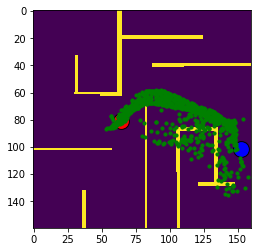

Iter: 491000
Loss: 0.001522

Iter: 492000
Loss: 0.001544

Iter: 493000
Loss: 0.001403

Iter: 494000
Loss: 0.001479

Iter: 495000
Loss: 0.001399

Iter: 496000
Loss: 0.001483

Iter: 497000
Loss: 0.001516

Iter: 498000
Loss: 0.001362

Iter: 499000
Loss: 0.001487



In [19]:
# Train  model and save weights after each ITERS_PER_SAVE
saver = tf.train.Saver()
for i in range(it, TRAIN_ITERS):
    # randomly generate batches
    batch_elements = [randint(0,numTrain-1) for n in range(0,mb_size)]
    X_mb = x_train[batch_elements,:]
    c_mb = cond_train[batch_elements,:]

    _, loss = sess.run([train_step, cvae_loss], feed_dict={X: X_mb, c: c_mb})

    if i % 1000 == 0:
        print('Iter: {}'.format(i))
        print('Loss: {:.4}'. format(loss))
        print()
    if i % ITERS_PER_SAVE == 0:
      saver.save(sess, MODEL_DIR+'/model_for_map%d_iter%d' % (MAP_NUM, i), write_meta_graph=False)
      NUM_SAMPLES = 1000  # number of samples for model to generate
      rand_test_i = randint(0,numTest-1)
      rand_cond = cond_test[rand_test_i, :]
      init = rand_cond[:STATE_DIM] * SAMPLE_SCALE_UP
      goal = rand_cond[STATE_DIM:2*STATE_DIM] * SAMPLE_SCALE_UP

      # same condition repeated NUM_SAMPLES times
      cond_samples = np.repeat([rand_cond],NUM_SAMPLES,axis=0)  

      # directly sample from the latent space to generate predicted samples
      gen_samples, _ = sess.run([y, z], feed_dict={z: np.random.randn(NUM_SAMPLES, z_dim), c: cond_samples})
      # scale up samples to original map dimension
      gen_samples = gen_samples * SAMPLE_SCALE_UP

      plt.imshow(orig_map)
      plt.scatter(x=init[1], y=init[0], color="red", s=250, edgecolors='black') # init
      plt.scatter(x=goal[1], y=goal[0], color="blue", s=250, edgecolors='black') # goal
      plt.scatter(x=gen_samples[:,1], y=gen_samples[:,0], color="green", s=10) # samples

      plt.show()


# Testing 

In [35]:
tf.reset_default_graph()
# Testing initialisation
sess_test = tf.Session()
# sess_test.run(tf.initialize_all_variables())
saver = tf.train.import_meta_graph(MODEL_DIR+'/graph.meta')
saver = tf.train.Saver()
saver.restore(sess_test, tf.train.latest_checkpoint(MODEL_DIR))
# Add code here to load models

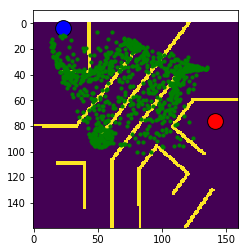

In [40]:

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data
 
NUM_SAMPLES = 1000  # number of samples for model to generate

rand_test_i = randint(0,numTest-1)
rand_cond = cond_test[rand_test_i, :]
init = rand_cond[:STATE_DIM] * SAMPLE_SCALE_UP
goal = rand_cond[STATE_DIM:2*STATE_DIM] * SAMPLE_SCALE_UP

# same condition repeated NUM_SAMPLES times
cond_samples = np.repeat([rand_cond],NUM_SAMPLES,axis=0)  
gen_samples=None
# directly sample from the latent space to generate predicted samples
z = sess_test.graph.get_tensor_by_name('Add:0')
c = sess_test.graph.get_tensor_by_name('c:0')
y = sess_test.graph.get_tensor_by_name('dense_6/BiasAdd:0')
gen_samples, _ = sess_test.run([y, z], feed_dict={z: np.random.randn(NUM_SAMPLES, z_dim), c: cond_samples})
# scale up samples to original map dimension
gen_samples = gen_samples * SAMPLE_SCALE_UP

plt.imshow(orig_map)
plt.scatter(x=init[1], y=init[0], color="red", s=250, edgecolors='black') # init
plt.scatter(x=goal[1], y=goal[0], color="blue", s=250, edgecolors='black') # goal
plt.scatter(x=gen_samples[:,1], y=gen_samples[:,0], color="green", s=10) # samples

plt.show()

In [ ]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

In [31]:
MODEL_DIR

'./Models/01'

In [ ]:
goal/SAMPLE_SCALE_UP